In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

In [ ]:
df = pd.read_csv(r'data/train.csv')
test = pd.read_csv(r'data/test.csv')

In [3]:
df = df[['price','host_is_superhost','host_has_profile_pic','host_identity_verified','latitude','longitude','accommodates'
        ,'beds','minimum_nights','maximum_nights','has_availability','availability_30','availability_60',
        'availability_90','availability_365','number_of_reviews','review_scores_rating','instant_bookable',
        'number_of_reviews_ltm','number_of_reviews_l30d','host_since']]
test = test[['host_is_superhost','host_has_profile_pic','host_identity_verified','latitude','longitude','accommodates',
             'beds','minimum_nights','maximum_nights','has_availability','availability_30','availability_60',
             'availability_90','availability_365','number_of_reviews','review_scores_rating','instant_bookable',
             'number_of_reviews_ltm','number_of_reviews_l30d','host_since']]

In [4]:
#na_per_column = df.isna().sum()
#print(na_per_column)

In [5]:
#df.dtypes

In [6]:
df['host_since'] = pd.to_datetime(df['host_since'])
test['host_since'] = pd.to_datetime(test['host_since'])

df['host_since_days'] = (pd.to_datetime('2024-01-01') - df['host_since']).dt.days
test['host_since_days'] = (pd.to_datetime('2024-01-01') - test['host_since']).dt.days

df.drop('host_since',inplace=True,axis=1)
test.drop('host_since',inplace=True,axis=1)

In [7]:
bool_cols = ['host_is_superhost', 'host_identity_verified','host_has_profile_pic','has_availability','instant_bookable']
df[bool_cols] = df[bool_cols].applymap(lambda x: 1 if x == 't' else 0)
test[bool_cols] = test[bool_cols].applymap(lambda x: 1 if x == 't' else 0)

In [8]:
correlation = df.corr()
correlation_target = abs(correlation["price"])
relevant_features = correlation_target[correlation_target > 0.03] 

In [9]:
X_train = df.drop('price', axis=1)
y_train = df['price']

X_test = test
#y_test = test_df['target']

In [10]:
combined_latitude = pd.concat([X_train['latitude'], X_test['latitude']])
combined_longitude = pd.concat([X_train['longitude'], X_test['longitude']])

# Determine the bin edges for 'latitude' and 'longitude'
latitude_bins = pd.cut(combined_latitude, bins=50, retbins=True)[1]
longitude_bins = pd.cut(combined_longitude, bins=50, retbins=True)[1]

# Apply the bin edges to the 'latitude' and 'longitude' columns in both datasets
X_train['latitude_bin'] = pd.cut(X_train['latitude'], bins=latitude_bins, labels=False)
X_train['longitude_bin'] = pd.cut(X_train['longitude'], bins=longitude_bins, labels=False)

X_test['latitude_bin'] = pd.cut(X_test['latitude'], bins=latitude_bins, labels=False)
X_test['longitude_bin'] = pd.cut(X_test['longitude'], bins=longitude_bins, labels=False)

X_train = X_train.drop('latitude',axis = 1)
X_train = X_train.drop('longitude',axis = 1)
X_test = X_test.drop('longitude',axis = 1)
X_test = X_test.drop('latitude',axis = 1)

In [11]:
X_test = X_test.fillna(X_test.mean())
X_train = X_train.fillna(X_train.mean())

In [12]:
scaler = StandardScaler()
features_to_scale = ['maximum_nights', 'minimum_nights','availability_30','availability_60',
                     'availability_90','availability_365','number_of_reviews', 'review_scores_rating',
                     'number_of_reviews_ltm','number_of_reviews_l30d','host_since_days']
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train_log = np.log(y_train)
#y_test_log = np.log(y_test)


In [13]:
model = xgb.XGBRegressor(colsample_bytree = .5,learning_rate = .05,
                         max_depth = 12,n_estimators = 400)
model.fit(X_train, y_train_log)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [14]:
predict_test = model.predict(X_test)

In [15]:
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

In [16]:
print(predict_test)

[4.4337754 4.944277  4.688341  ... 4.405341  5.622337  5.004219 ]


In [17]:
predict_test_exp = np.exp(predict_test)
test_id_df = pd.read_csv('test.csv')
id_col = test_id_df['Id']



y_pred_df = pd.DataFrame(predict_test_exp, columns=['price'])
y_pred_df['Id'] = id_col.values
y_pred_df = y_pred_df[['Id', 'price']]

In [18]:
y_pred_df.reset_index(drop=True, inplace=True)
y_pred_df.to_csv('submission.csv',index=False)

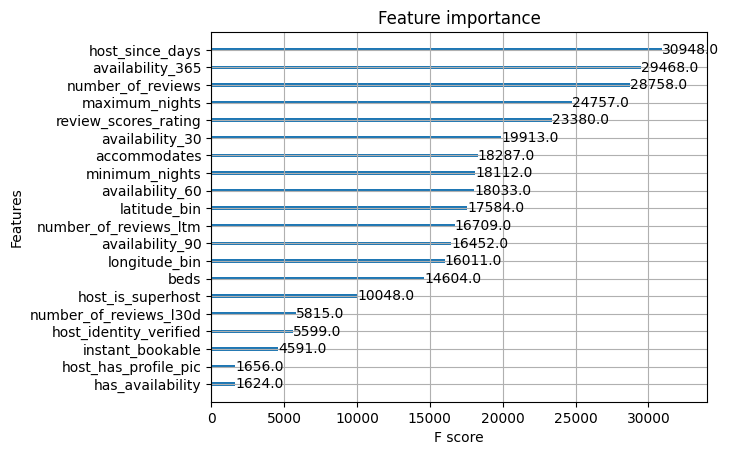

In [19]:
#import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming that your model is named 'model'
xgb.plot_importance(model)
plt.show()